# Welcome to the LIGO data visualization jupyter notebook tutorial! 

## Installation

Please make sure you have [GWpy](https://gwpy.github.io/docs/latest/install/index.html) installed before you begin!   
<span style="color:gray">Jess notes: I'd recommend via pip, and the following was produced using a python3.7 kernel. All code dependencies should be installed via those installation instructions except for python; careful with your python paths here.</span> 

### Learning goals

With this tutorial, you will learn how to: 

* Use basic GWOSC tools to query for LIGO-Virgo observing run times and event times 
* Import public LIGO data with GWpy 
* Plot a LIGO h(t) time series with GWpy
* Make a spectral density plot of a time series
* Apply and characterize a whitening filter
* Visualize LIGO data with spectrograms 

This tutorial borrows from the excellent work of Duncan Macleod, Jonah Kanner, Alex Nitz, and others involved in the [2018 GWOSC webcourse](https://www.gw-openscience.org/static/workshop1/course.html) - you can find many more great examples there. 

Let's get started! 

___

## Using GWOSC tools 

Here we'll use tools from the Gravitational Wave Open Science Center ([GWOSC](https://www.gw-openscience.org/about/)): [gwosc python module](https://gwosc.readthedocs.io/en/latest/), which we should have already installed via our GWpy install. 

First, let's see what's in these GWOSC datasets: 

In [1]:
from gwosc.datasets import find_datasets
find_datasets()

['151008',
 '151012A',
 '151116',
 '161202',
 '161217',
 '170208',
 '170219',
 '170405',
 '170412',
 '170423',
 '170616',
 '170630',
 '170705',
 '170720',
 'BKGW170608_16KHZ_R1',
 'GW150914',
 'GW151012',
 'GW151226',
 'GW170104',
 'GW170608',
 'GW170729',
 'GW170809',
 'GW170814',
 'GW170817',
 'GW170818',
 'GW170823',
 'GWTC-1-confident',
 'GWTC-1-marginal',
 'O1',
 'O1_16KHZ',
 'O2_16KHZ_R1',
 'O2_4KHZ_R1',
 'S5',
 'S6']

Here we see data for: 

* **[GWTC-1](https://arxiv.org/abs/1811.12907) confident events**: GW150914, GW151012, GW151226, GW170104, GW170608, GW170729, GW170809, GW170814, GW170817, GW170818, and GW170823
* **[GWTC-1](https://arxiv.org/abs/1811.12907) marginal events**: 151008, 151012A, 151116, 161202, 161217, 170208, 170219, 170405, 170412, 170423, 170616, 170630, 170705, 170720
* **Observing runs**: Advanced LIGO and Advanced Virgo observing runs O1 and O2 at different sampling rates, as well as past science runs S5 and S6 (pre 2010). 
* And background data for an event included in the GWTC-1 catalog, but not in the O2 data release: BKGW170608_16KHZ_R1

Knowing this, let's try to query for the start and end of LIGO-Virgo **observing runs**. Currently, data from the first two observing runs are available via the GWOSC: O1 and O2.

`gwosc.datasets.run_segment` will return the start and end GPS times for an observing run given a dataset tag. Let's try O1:

In [2]:
from gwosc.datasets import run_segment
print(run_segment('O1'))

(1126051217, 1137254417)


And O2: 

In [3]:
print(run_segment('O2'))

ValueError: no run dataset found for 'O2'

**There's an error here!** Can you find a way to fix the cell above and print the start and end times for the second LIGO-Virgo observing run (O2)? 

We can also query for event releases specifically by using `find_datasets` and specifying the `event` type. 

In [4]:
from gwosc.datasets import find_datasets
events = find_datasets(type='event')
print(events)

['151008', '151012A', '151116', '161202', '161217', '170208', '170219', '170405', '170412', '170423', '170616', '170630', '170705', '170720', 'GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729', 'GW170809', 'GW170814', 'GW170817', 'GW170818', 'GW170823']


If we want to know the GPS time of a particular event, we can grab that with `event_gps`. Let's try that for the first binary neutron star detection, GW170817. 

In [5]:
from gwosc.datasets import event_gps
GW170817gps = event_gps('GW170817')
print(GW170817gps)

1187008882.4


We can also filter our results by which gravitational wave detectors were active during the time of the event. 

***Detector tags:*** <br>
LIGO-Livingston = 'L1'<br>
LIGO-Hanford = 'H1'<br>
Virgo = 'V1'<br>
KAGRA = 'K1'<br>
GEO600 = 'G1'<br>


For example, let's see which events LIGO-Livingston was active for: 

In [6]:
find_datasets(type='event', detector='L1')

['151008',
 '151012A',
 '151116',
 '161202',
 '161217',
 '170208',
 '170219',
 '170405',
 '170412',
 '170423',
 '170616',
 '170630',
 '170705',
 '170720',
 'GW150914',
 'GW151012',
 'GW151226',
 'GW170104',
 'GW170608',
 'GW170729',
 'GW170809',
 'GW170814',
 'GW170817',
 'GW170818',
 'GW170823']

### Exercises for using the GWOSC tools 

* How many events were detected during O2?
* Which O2 event releases include data for the Virgo detector?

----
## Importing open LIGO data 

We can use GWpy to import a LIGO time series from the GWOSC with `fetch_open_data`. Let's try to grab some data around a detected event, say GW150914 (the very first direct gravitational wave detection).

Note: The first time to import `gwpy.timeseries`, matplotlib may try to import some extra fonts and that can take a couple minutes.

In [7]:
# Import
from gwpy.timeseries import TimeSeries

In [8]:
# Grab the event gps time with GWOSC tools
GW150914gps = event_gps('GW150914')
print(GW150914gps)

1126259462.4


In [9]:
# Set a start and end time around the event time (in units of seconds) to import LIGO data 
window = 5
start = GW150914gps - window
end = GW150914gps + window

# Check that this looks sane
print('start time GPS = '+str(start))
print('end time GPS = '+str(end))

start time GPS = 1126259457.4
end time GPS = 1126259467.4


Now that we've identified a time range of interest, we can grab some data. Let's choose the LIGO-Hanford detector (H1). 

In [10]:
# Grab H1 data around the time of interest from the GWOSC
data = TimeSeries.fetch_open_data('H1', start, end, verbose=True)
print(data)

Fetched 1 URLs from www.gw-osc.org for [1126259457 .. 1126259468))
Reading data... [Done]
TimeSeries([ 6.23360521e-20,  3.83408750e-20, -3.87735260e-21,
            ..., -1.00141128e-19, -1.05876825e-19,
            -1.30391760e-19]
           unit: dimensionless,
           t0: 1126259457.3999023 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/gwpy/types/series.py:921: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


Requiring `verbose=True` gives us details on the data download (and helps with debugging if needed).

*The downloaded file is not stored permanently!* If you run this cell again it will be downloaded again. However, you can use `cache=True` to store the file on your computer if you like.

## Plot a LIGO time series 

We can use GWpy to plot the data we downloaded from the GWOSC by calling the `plot()` method of our `data` object. <br>
<span style="color:gray">Jess note: This may take 2-3 minutes to render the first time.</span>


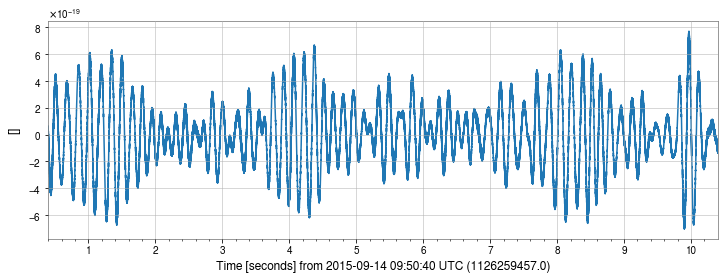

In [12]:
plot = data.plot()

This is the real LIGO data (one of two detectors) used to make the first direct detection of GWs. Do you spot the signal yet?

Let's add a title and y-axis labels to make it more clear what we're looking at. 

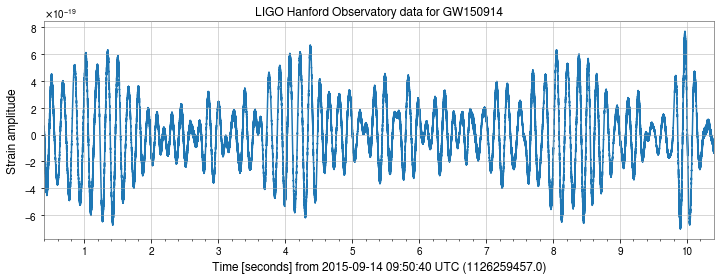

In [13]:
plot = data.plot(
    title='LIGO Hanford Observatory data for GW150914',
    ylabel='Strain amplitude'
)

Nice.

## Make a spectral density plot

What does the data containing the signal look like in the frequency domain? 

We can then call the `asd()` method to calculate the amplitude spectral density and tranform our `TimeSeries` into a `FrequencySeries`.

Syntax:
`asd(FFT_length_in_seconds, FFT_overlap_in_seconds, default_time_window='hann', default_FFT_method='welch')`

In [14]:
gw140914asd = data.asd(5, 2)
print(gw140914asd)

FrequencySeries([1.43284784e-20, 2.82231920e-20, 1.31071515e-20,
                 ..., 1.49785405e-25, 1.33796891e-25,
                 3.14417048e-26]
                unit: 1 / Hz(1/2),
                f0: 0.0 Hz,
                df: 0.2 Hz,
                epoch: 1126259457.399902,
                name: Strain,
                channel: None,
                frequencies: None)


Now we can make a plot of our `FrequencySeries` with the same method we used for a `TimeSeries`.
Let's add some labels and zoom in on the frequency range of interest, the most sensitive frequency range of the detector. 

(30, 500)

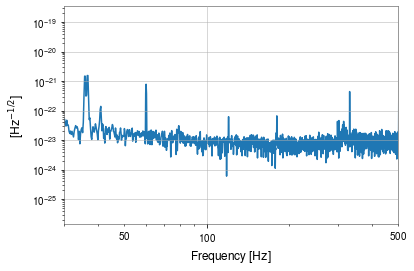

In [19]:
plot = gw140914asd.plot()
ax = plot.gca()
ax.set_xlim(30, 500)

**Exercise**: Remake this plot with a better view of the spectral amplitude content (i.e. zoom in on the y-axis).

---

How does this spectrum compare to one without a signal in it? 

Let's find out by generating another spectrum from a slightly earlier 'off source' time, let's say 10 seconds before our start time, but with the same time window as before.

In [20]:
offsourcestart = start - 10
offsourceend = offsourcestart + 2*window
print(offsourcestart)
print(offsourceend)

1126259447.4
1126259457.4


In [21]:
offsourcedata = TimeSeries.fetch_open_data('H1', offsourcestart, offsourceend, verbose=True)

Fetched 1 URLs from www.gw-osc.org for [1126259447 .. 1126259458))
Reading data... [Done]


/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/gwpy/types/series.py:921: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


In [22]:
offsourceasd = offsourcedata.asd(5, 2)

(30, 500)

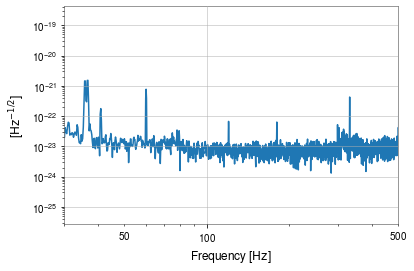

In [24]:
plot = offsourceasd.plot()
ax = plot.gca()
ax.set_xlim(30, 500)

It's still hard to tell... let's overlay our spectrum from GW150914 and our 'off source' time.

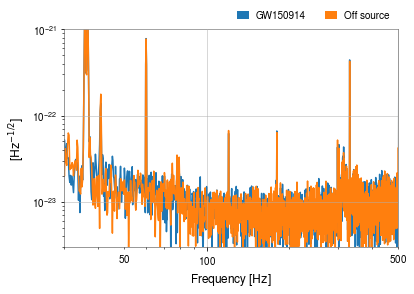

In [27]:
plot = gw140914asd.plot(label='GW150914')
ax = plot.gca()
ax.plot(offsourceasd, label='Off source')
ax.set_xlim(30, 500)
ax.set_ylim(3e-24, 1e-21)
ax.legend(frameon=False, bbox_to_anchor=(1., 1.), loc='lower right', ncol=2)

It looks like there'a a bit of excess power here during the time of GW150914 relative to an earlier time - perhaps the frequency content of our data is changing as a function of time? 

## Apply and characterize a whitening filter

It's much easier to spot excess power in the data if we can weight it by the frequency contributions that are consistent over time. 

We can use GWpy to `whiten` our data for the time of GW150914.


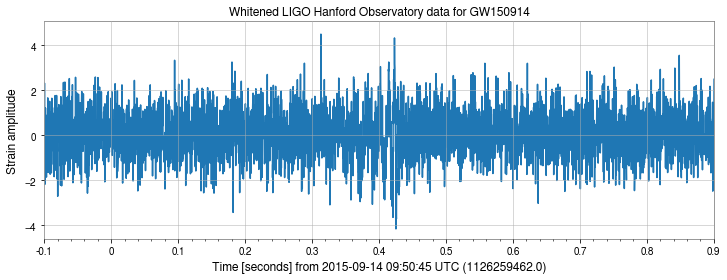

In [28]:
whitened_gw150914 = data.whiten(2,1)
plot = whitened_gw150914.plot(
    title='Whitened LIGO Hanford Observatory data for GW150914',
    ylabel='Strain amplitude',
    xlim=(GW150914gps-0.5, GW150914gps+0.5)
)

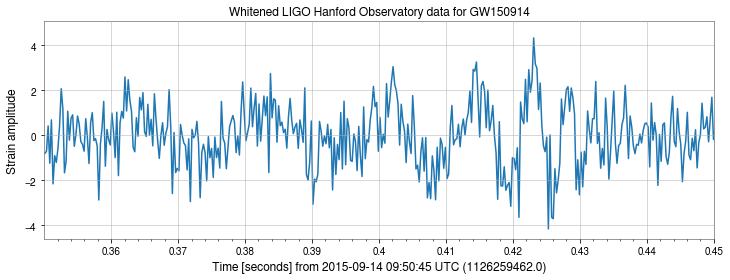

In [29]:
whitened_gw150914 = data.whiten(2,1)
plot = whitened_gw150914.plot(
    title='Whitened LIGO Hanford Observatory data for GW150914',
    ylabel='Strain amplitude',
    xlim=(GW150914gps-0.05, GW150914gps+0.05)
)

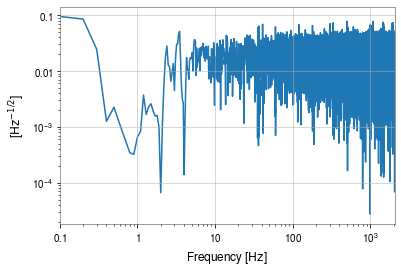

In [30]:
whitened_gw150914_asd = whitened_gw150914.asd()
plot = whitened_gw150914_asd.plot()

### Challenge for filtering in the frequency domain

Using the spectrum of the whitened ASD for reference, can you improve the whitening of GW150914 to make the signal more clear? (Ideally T-shirt quality.) 


## Visualize LIGO data with spectrograms

A great way to visualize how the frequency content of our data is changing over time is with whitened spectrograms. 

Let's try it for GW150914. 

We can employ the `spectrogram2()` method in GWpy on our whitened data, and set some other formatting variables to make the plot look nice: 

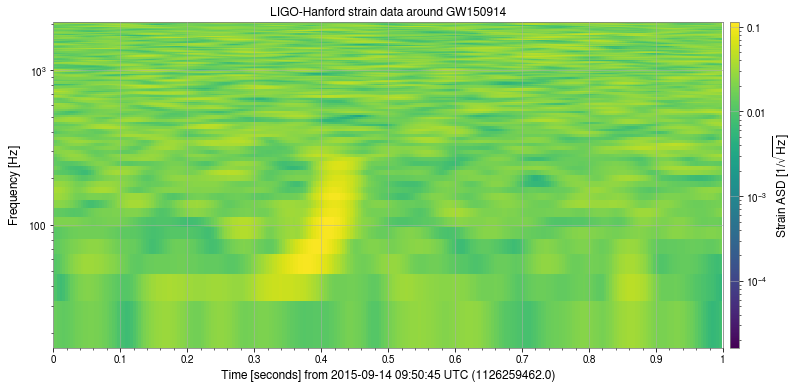

In [31]:
specgram = whitened_gw150914.spectrogram2(fftlength=1/16., overlap=15/256.) ** (1/2.)
plot = specgram.plot(norm='log', cmap='viridis', yscale='log')
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data around GW150914')
ax.set_xlim(1126259462, 1126259463)
ax.colorbar(label=r'Strain ASD [1/$\sqrt{\mathrm{Hz}}$]')

There is something there! It looks like it's sweeping up in frequency over time, but it's still hard to make out the details. 

To zoom in even further, we can employ a [muli-resolution technique](https://arxiv.org/abs/gr-qc/0412119) called the [Q transform](https://gwpy.github.io/docs/latest/api/gwpy.timeseries.TimeSeries.html?highlight=q_transform#gwpy.timeseries.TimeSeries.q_transform). 

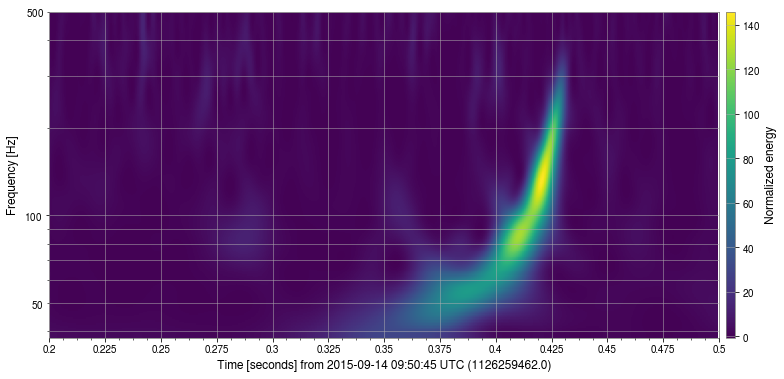

In [32]:
qspecgram = data.q_transform(outseg=(1126259462.2, 1126259462.5))
plot = qspecgram.plot()
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(38, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')

There it is. Nice work! 

### Challenge

Try to generate a frequency vs. time plot of LIGO data around the binary neutron star event (GW170817) where you can clearly see the signal track. (Hints: consider using LIGO-Livingston data, a Q transform, and a longer duration of data).

---

If you still have some free time, try to improve your whitening in the module above, and see what effect this has on your whitened spectrogram.